# LinUCB

### References
https://arxiv.org/pdf/1003.0146.pdf

- https://github.com/ikatsov/tensor-house/blob/master/promotions/dynamic-content-personalization-rl.ipynb
- https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_disjoint.ipynb

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from tqdm.autonotebook import tqdm

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_84859/1586460767.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Create a Baseline Recommendation Agent - UCB 

In [2]:
class UCBAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.action_total_rewards = np.zeros(self.n_actions)
        self.action_counters = np.ones(self.n_actions)
        self.alpha = 0.5

    def pull(
        self, state: dict
    ) -> np.ndarray:  # state vector is not used (context-free agent)
        steps = np.sum(self.action_counters)
        mean_reward_a = self.action_total_rewards / steps
        bound_a = np.sqrt(self.alpha * np.log(steps) / self.action_counters)
        ucbs = mean_reward_a + bound_a
        return ucbs

    def update(
        self, state: dict, action: int, reward: int
    ):  # state vector is not used (context-free agent)
        self.action_total_rewards[action] += reward
        self.action_counters[action] += 1

In [3]:
class RandomAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def pull(
        self, state: dict
    ) -> np.ndarray:  # state vector is not used (context-free agent)
        return np.random.uniform(size=self.n_actions)

    def update(
        self, state: dict, action: int, reward: int
    ):  # state vector is not used (context-free agent)
        pass

## Create a Context-aware Agent - LinUCB

In [4]:
class LinUCBAgent:
    def __init__(
        self,
        n_actions,
        context_size=100,
        preprocess=FeatureHasher(100, input_type="string"),
    ):
        self.n_actions = n_actions
        self.alpha = 0.5
        self.A = [np.identity(context_size) for a in range(self.n_actions)]
        self.b = [np.zeros((context_size, 1)) for a in range(self.n_actions)]
        self.preprocess = preprocess

    def pull(self, state: dict) -> np.ndarray:  # state vector is used
        ucbs = np.zeros(self.n_actions)
        for action_idx in range(self.n_actions):
            x_a = self.preprocess.transform(
                [feature_interaction(state, action_idx)]
            ).toarray()[0]
            A_inv = np.linalg.inv(self.A[action_idx])
            theta_a = np.dot(A_inv, self.b[action_idx])
            ucb = np.dot(theta_a.T, x_a) + self.alpha * np.sqrt(
                np.linalg.multi_dot([x_a.T, A_inv, x_a])
            )
            ucbs[action_idx] = ucb[0]
        return ucbs

    def update(self, state: dict, action: int, reward: int):
        x = np.atleast_2d(
            self.preprocess.transform([feature_interaction(state, action)]).toarray()
        )
        self.A[action] += np.dot(x.T, x)
        self.b[action] += reward * np.atleast_2d(x).T

In [5]:
import bandit
from bandit.bandit import Bandit, PerArmBandit
from bandit.environment import actions, feature_interaction, get_cost, observe
from bandit.policy import EGreedy

N = 500
df = pd.DataFrame(index=range(N))

In [6]:
def run_simulation(bandit, policy):
    rng = np.random.RandomState(42)
    total_cost = 0
    avg_cost = []
    for i in tqdm(range(N)):
        state = observe(rng)
        rewards = bandit.pull(state)
        action = policy(rewards)
        reward = get_cost(state, actions[action])
        # Sets rewards to 0 or 1 (instead of -1 or 1)
        reward = max(reward, 0)
        bandit.update(state, action, reward)
        total_cost += reward
        avg_cost.append(total_cost / (i + 1))
    return total_cost, avg_cost

In [7]:
n_arms = len(actions)
bandits = [RandomAgent(n_arms), UCBAgent(n_arms), LinUCBAgent(n_arms)]
policy = EGreedy(epsilon=0)

for bandit in bandits:
    name = bandit.__class__.__name__
    total_cost, avg_cost = run_simulation(bandit, policy)
    print(name, total_cost)
    df[name] = avg_cost

  0%|          | 0/500 [00:00<?, ?it/s]

RandomAgent 57.0


  0%|          | 0/500 [00:00<?, ?it/s]

UCBAgent 169.0


  0%|          | 0/500 [00:00<?, ?it/s]

LinUCBAgent 369.0


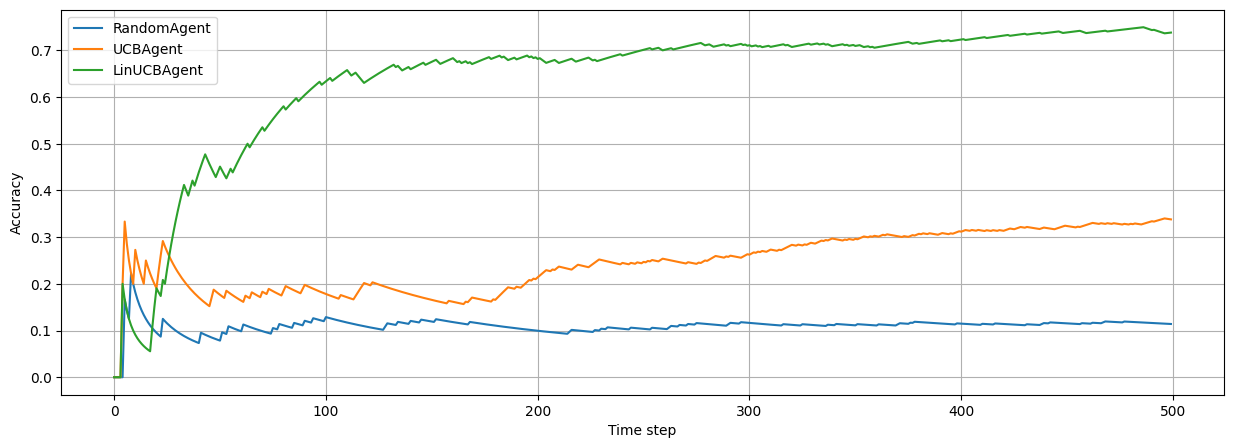

In [8]:
ax = df.plot(figsize=(15, 5))
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
ax.grid(True)

## Observation

Why does UCBAgent fail so miserably? This is because it does not have context (no pun intended) on what is the best arm to pick. UCBAgent works better for a fixed set of actions. Below, we see that it tries to optimize for action `0`, which is politics, because we set in the environment that both Tom and Anna likes `politic` at specific hours.

In [10]:
bandit = bandits[1]
bandit.__dict__

{'n_actions': 7,
 'action_total_rewards': array([158.,   5.,   6.,   0.,   0.,   0.,   0.]),
 'action_counters': array([357.,  27.,  27.,  24.,  24.,  24.,  24.]),
 'alpha': 0.5}